In [58]:
#Import packages 
import autograd.numpy as np
from autograd import jacobian
from numpy import genfromtxt
import scipy
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import Bounds
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family ='serif',size=12)
from palettable.colorbrewer.sequential import Blues_8
colors = Blues_8.mpl_colormap(np.linspace(0,6))


# GOH
Gasser et al 2006(https://doi.org/10.1098/rsif.2005.0073)


Incompressible material assumption
$$\Psi_1(J) = p(1-J)$$
$$\Psi_2(\mathbf{C}) = \frac{\mu}{2}(I_1 -3) +\frac{k_1}{2k_2}[e^{(k_2[\kappa I_1 + (1-3\kappa)I_4-1]^2)}-1]$$
Here $I_4 = \mathbf{C}:\mathbf{M} =\mathbf{C}:  \mathbf{a}_0\otimes \mathbf{a}_0$

Let $\mathbf{H} =\kappa I_1 + (1-3\kappa)I_4$ and $\mathbf{E} = [\mathbf{H}-1]$

$$\mathbf{S}_1  = 2\frac{\partial \Psi_{1}}{\partial \mathbf{C}} = -pC^{-1} $$
$$\mathbf{S}_2  =  2\frac{\partial \Psi_{2}}{\partial \mathbf{C}} = \mu \mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK2 stress

$$\mathbf{S} = -p\mathbf{C}^{-1} +  \mu\mathbf{I} + 2k_1 e^{k_2\mathbf{E}^2}\mathbf{E}[\kappa \mathbf{I}+(1-3\kappa)\mathbf{M}]$$

Total PK1 stress

$$\mathbf{P} = \mathbf{F}\mathbf{S}$$

In [59]:
def evalP(par,lam1,lam2):
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    a0 = np.array([np.cos(alpha),np.sin(alpha),0])
    M = np.outer(a0,a0)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
#     C = np.array([[lam1 ,0, 0],[0,lam2, 0] ,[0, 0, lam3]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4 = np.tensordot(C,M)
    
    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*np.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
#     print(p)
    
    P =  F*S
    return P

# Import all relevant data and form data frames

Visualize data here to insepct. Correct the files before proceeding to fitting

In [60]:
path ="../Stress_Stretch_Control/"
Exp = "P1C1"
A_Offx = path+Exp+"S1_OffX.csv"
A_Offy = path+Exp+"S1_OffY.csv"
A_Equi = path+Exp+"S4_Equibiaxial.csv"

In [61]:
AX = genfromtxt(A_Offx,delimiter=',')
AY = genfromtxt(A_Offy,delimiter=',')
AE = genfromtxt(A_Equi,delimiter=',')
A = np.vstack([AX,AY])

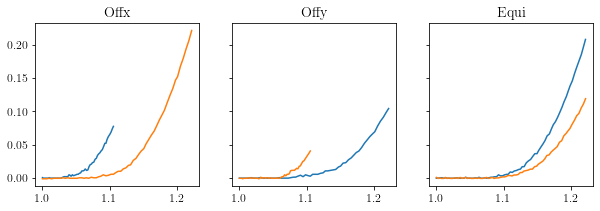

In [62]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
ax[0].plot(AX[:,0],AX[:,1])
ax[0].plot(AX[:,2],AX[:,3])
ax[0].set_title("Offx")
ax[1].plot(AY[:,0],AY[:,1])
ax[1].plot(AY[:,2],AY[:,3])
ax[1].set_title("Offy")
ax[2].plot(AE[:,0],AE[:,1])
ax[2].plot(AE[:,2],AE[:,3])
ax[2].set_title("Equi")
plt.show()

## Objective function for fitting 

In [63]:
def ObjA(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jacA = jacobian(ObjA) # Jacobian of the objctive function using Autograd


par = [1,1,1,1/6,np.pi/4] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,-np.pi/2],[10.,10.,1000.,1/3,np.pi/2] ) #Bounds on parameters

### Run the optimizer and inspect the results

In [64]:
optA = scipy.optimize.minimize(ObjA,par,jac=jacA,bounds = bounds)
print("Optim for A ",optA.x)

Optim for A  [9.86876414e-04 5.64353050e-01 7.95242698e+01 2.94747207e-01
 1.57079633e+00]


#### Plot

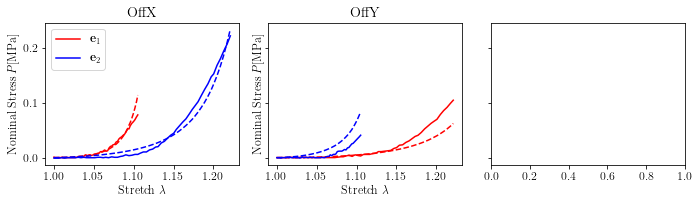

In [65]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)

lam1_1 = AX[:,0]
lam1_2 = AX[:,2]
PE1_1 = AX[:,1]
PE1_2 = AX[:,3]
Parr1 = np.zeros([len(lam1_1),2])
for i in range(0,len(lam1_1)):
        P = evalP(optA.x,lam1_1[i],lam1_2[i])
        Parr1[i,0] = P[0,0]
        Parr1[i,1] = P[1,1]

        
lam2_1 = AY[:,0]
lam2_2 = AY[:,2]
PE2_1 = AY[:,1]
PE2_2 = AY[:,3]
Parr2 = np.zeros([len(lam2_1),2])
for i in range(0,len(lam2_1)):
        P = evalP(optA.x,lam2_1[i],lam2_2[i])
        Parr2[i,0] = P[0,0]
        Parr2[i,1] = P[1,1]

lam3_1 = AE[:,0]
lam3_2 = AE[:,2]
PE3_1 = AE[:,1]
PE3_2 = AE[:,3]
Parr3 = np.zeros([len(lam3_1),2])
for i in range(0,len(lam3_1)):
        P = evalP(optA.x,lam3_1[i],lam3_2[i])
        Parr3[i,0] = P[0,0]
        Parr3[i,1] = P[1,1]
        
ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')       
ax[0].plot(lam1_1,Parr1[:,0],'--',color='r')
ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,Parr1[:,1],'--',color='b') 
ax[0].set_title("OffX")
ax[0].set_xlabel(r'Stretch $\lambda$')
ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
ax[0].legend()

ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')       
ax[1].plot(lam2_1,Parr2[:,0],'--',color='r')
ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,Parr2[:,1],'--',color='b')  
ax[1].set_title("OffY")
ax[1].set_xlabel(r'Stretch $\lambda$')
ax[1].set_ylabel(r'Nominal Stress $P$[MPa]')


# ax[2].plot(lam3_1,PE3_1,color='r',label=r'$\mathbf{e}_1$')       
# ax[2].plot(lam3_1,Parr3[:,0],'--',color='r')
# ax[2].plot(lam3_2,PE3_2,color='b',label=r'$\mathbf{e}_2$')       
# ax[2].plot(lam3_2,Parr3[:,1],'--',color='b')  
# ax[2].set_title("Equi")
# ax[2].set_xlabel(r'Stretch $\lambda$')
# ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')

plt.tight_layout()
plt.savefig("Img/"+Exp+".png",dpi=300)
plt.show()


# Bayesian

In [9]:
import numpy as np
from autograd import numpy as anp, elementwise_grad as egrad

import theano as th
from theano import shared, function, tensor as tt
import pymc3 as pm

import math
import scipy.stats as st
import scipy

In [10]:
lam1  = A[:,0]
lam2  = A[:,2]
lam = shared(np.vstack([lam1,lam2]).T)
P_Obs = shared(np.vstack([A[:,1],A[:,3]]))

In [11]:
def PK1_theano(lam,par):
    lam1 = lam[0]
    lam2 = lam[1]
    mu = par[0]
    k1 = par[1]
    k2 = par[2]
    kappa = par[3]
    alpha = par[4]
    
    #Structure tensor
    M = tt.zeros((3, 3))
    M = tt.set_subtensor(M[0, 0], tt.cos(alpha)**2)
    M = tt.set_subtensor(M[0, 1], tt.cos(alpha)*tt.sin(alpha))
    M = tt.set_subtensor(M[1, 0], tt.cos(alpha)*tt.sin(alpha))
    M = tt.set_subtensor(M[1, 1], tt.sin(alpha)**2)
    
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = tt.zeros((3, 3))
    F = tt.set_subtensor(F[0, 0],lam1)
    F = tt.set_subtensor(F[1, 1],lam2)
    F = tt.set_subtensor(F[2, 2],lam3)
    C = tt.dot(F.T,F)
    
    invF = tt.nlinalg.matrix_inverse(F)
    invC = tt.nlinalg.matrix_inverse(C)
    I = tt.zeros((3, 3))
    I = tt.set_subtensor(I[0, 0],1.0)
    I = tt.set_subtensor(I[1, 1],1.0)
    I = tt.set_subtensor(I[2, 2],1.0)
    
    
    #Invariants
    I1 = tt.nlinalg.trace(C)
    I4 = tt.tensordot(C,M)

    
    #Evaluate stress
    H = kappa*I1+(1-3*kappa)*I4
    E = H-1
    S2 = mu*I+2*k1*tt.exp(k2*E**2)*E*(kappa*I+(1-3*kappa)*M)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
    P =  tt.dot(F,S)
    return P

In [12]:
def PK1_long(par):
    values, _ = th.scan(fn=PK1_theano, sequences = [lam[:]] , non_sequences=par, n_steps= lam.shape[0])
    P1 = values[:,0,0]
    P2 = values[:,1,1]
    P_Pred = tt.stack([P1, P2])
    return P_Pred

In [22]:
with pm.Model() as model:
    sig = pm.InverseGamma('sigma',alpha=1.0,beta=1.0) #Strictly positive prior on these params
#     sig = 0.001 # Assume very tiny measurement noise
    mu = pm.InverseGamma('mu',alpha=1.0,beta=1.0)
    k1 = pm.InverseGamma('k1',alpha=1.0,beta=1.0)
    k2 = pm.InverseGamma('k2',alpha=1.0,beta=1.0)
    kappa = pm.Uniform('kappa',lower=0.0,upper=0.333333333) # Non-informative prior on orientation and distribution
    alpha = pm.Uniform('alpha',lower=0,upper=np.pi)
    param = tt.as_tensor_variable([mu,k1,k2,kappa,alpha])
    P_mean = pm.Deterministic('P_mean', PK1_long(param))
    P = pm.Normal(name='P',mu= P_mean,sigma=sig,observed=P_Obs)

In [23]:
with model:
    mcmc_res = pm.sample(draws =2000, step=pm.NUTS())

/Users/vivekdharmangadansree/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, kappa, k2, k1, mu, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3617 seconds.
The acceptance probability does not match the target. It is 0.9029281386378957, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


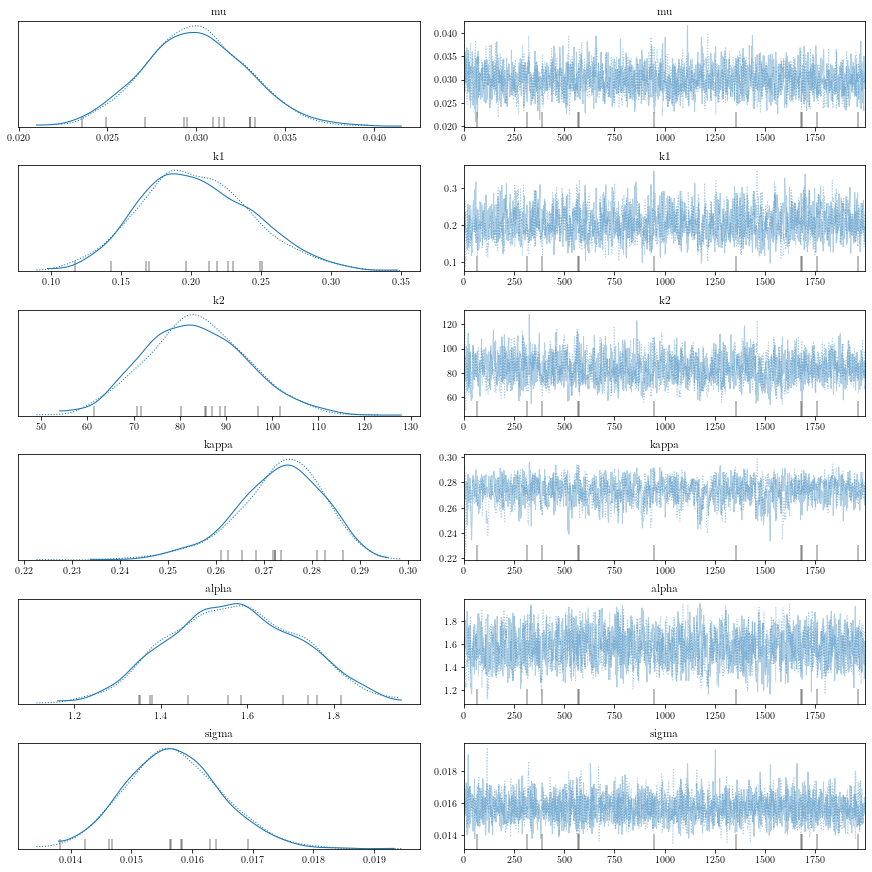

In [54]:
# fig = {'figsize':(12, 4)}
_ = pm.traceplot(mcmc_res,var_names=['mu','k1','k2','kappa','alpha','sigma']) 

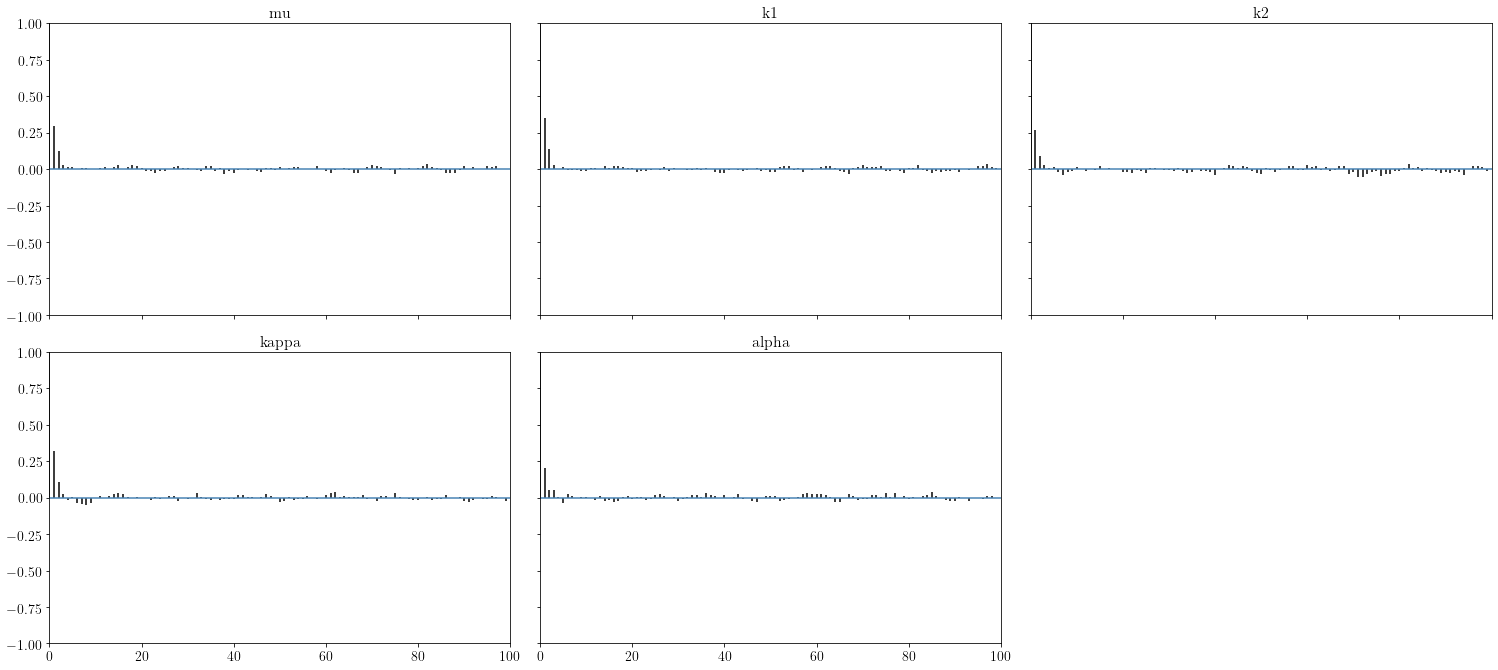

In [17]:
# _=pm.plot_autocorr(mcmc_res,var_names=['mu','k1','k2','kappa','alpha'], combined=True)

In [25]:
ppsamples_A = pm.sample_posterior_predictive(samples=2000,\
                                           model=model, 
                                           trace=mcmc_res)['P']
pp_mean = np.mean([x for x in ppsamples_A],axis=0)
pp_lower, pp_upper = np.percentile([x for x in ppsamples_A],axis=0,q=[2.5, 97.5])


/Users/vivekdharmangadansree/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 1.0, 'Offy')

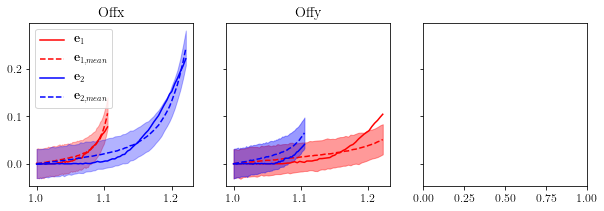

In [26]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')
ax[0].plot(lam1_1,pp_mean[0][0:len(lam1_1)],'--',color='r',label=r'$\mathbf{e}_{1,mean}$')
ax[0].fill_between(lam1_1,pp_lower[0][:len(lam1_1)],pp_upper[0][:len(lam1_1)], color='r',alpha=0.3)
ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,pp_mean[1][0:len(lam1_2)],'--',color='b',label=r'$\mathbf{e}_{2,mean}$')
ax[0].fill_between(lam1_2,pp_lower[1][0:len(lam1_2)],pp_upper[1][0:len(lam1_2)], color='b',alpha=0.3)
ax[0].set_title("Offx")
ax[0].legend(loc='best')

ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')
ax[1].plot(lam2_1,pp_mean[0][len(lam1_1):len(lam1_1)+len(lam2_1)],'--',color='r',label=r'$\mathbf{e}_{1,mean}$')
ax[1].fill_between(lam2_1,pp_lower[0][len(lam1_1):len(lam1_1)+len(lam2_1)],pp_upper[0][len(lam1_1):len(lam1_1)+len(lam2_1)], color='r',alpha=0.4)
ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,pp_mean[1][len(lam1_2):len(lam1_2)+len(lam2_2)],'--',color='b',label=r'$\mathbf{e}_{2,mean}$')
ax[1].fill_between(lam2_2,pp_lower[1][len(lam1_2):len(lam1_2)+len(lam2_2)],pp_upper[1][len(lam1_2):len(lam1_2)+len(lam2_2)], color='b',alpha=0.4)
ax[1].set_title("Offy")

In [55]:
ppsamples = pm.sample_posterior_predictive(samples=1000,model=model,trace=mcmc_res,var_names=['mu','k1','k2','kappa','alpha','P_mean','P'])
ppsamples_A = ppsamples["P_mean"]
pp_mean = np.mean([x for x in ppsamples_A],axis=0)
pp_lower, pp_upper = np.percentile([x for x in ppsamples_A],axis=0,q=[2.5, 97.5])

/Users/vivekdharmangadansree/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


Text(0.5, 1.0, 'Offy')

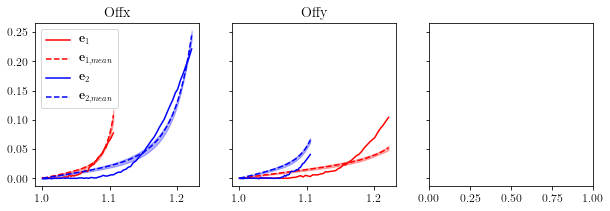

In [30]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)
ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')
ax[0].plot(lam1_1,pp_mean[0][0:len(lam1_1)],'--',color='r',label=r'$\mathbf{e}_{1,mean}$')
ax[0].fill_between(lam1_1,pp_lower[0][:len(lam1_1)],pp_upper[0][:len(lam1_1)], color='r',alpha=0.3)
ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,pp_mean[1][0:len(lam1_2)],'--',color='b',label=r'$\mathbf{e}_{2,mean}$')
ax[0].fill_between(lam1_2,pp_lower[1][0:len(lam1_2)],pp_upper[1][0:len(lam1_2)], color='b',alpha=0.3)
ax[0].set_title("Offx")
ax[0].legend(loc='best')

ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')
ax[1].plot(lam2_1,pp_mean[0][len(lam1_1):len(lam1_1)+len(lam2_1)],'--',color='r',label=r'$\mathbf{e}_{1,mean}$')
ax[1].fill_between(lam2_1,pp_lower[0][len(lam1_1):len(lam1_1)+len(lam2_1)],pp_upper[0][len(lam1_1):len(lam1_1)+len(lam2_1)], color='r',alpha=0.3)
ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,pp_mean[1][len(lam1_2):len(lam1_2)+len(lam2_2)],'--',color='b',label=r'$\mathbf{e}_{2,mean}$')
ax[1].fill_between(lam2_2,pp_lower[1][len(lam1_2):len(lam1_2)+len(lam2_2)],pp_upper[1][len(lam1_2):len(lam1_2)+len(lam2_2)], color='b',alpha=0.3)
ax[1].set_title("Offy")

In [50]:
def evalPP(par,lam1,lam2):
    mu = par[0]
    k1_1 = par[1]
    k2_1 = par[2]
    kappa1 = par[3]
    alpha1 = par[4]
    k1_2 = par[5]
    k2_2 = par[6]
    kappa2 = par[7]
    alpha2 = par[8]
    
    #Structure tensor
    a1 = np.array([np.cos(alpha1),np.sin(alpha1),0])
    a2 = np.array([np.cos(alpha2),np.sin(alpha2),0])
    M1 = np.outer(a1,a1)
    M2 = np.outer(a2,a2)
                 
    #Kinematics
    lam3 = 1/(lam1*lam2)
    F = np.array([[(lam1) ,0., 0],[0.,(lam2), 0] ,[0., 0,(lam3)]])
#     C = np.array([[lam1 ,0, 0],[0,lam2, 0] ,[0, 0, lam3]])
    C = F.T*F
    invF = np.linalg.inv(F)
    invC = np.linalg.inv(C)
    I = np.eye(3)
    
    #Invariants
    I1 = np.trace(C)
    I4_1 = np.tensordot(C,M1)
    I4_2 = np.tensordot(C,M2)
    
    
    #Evaluate stress
    H1 = kappa1*I1+(1-3*kappa1)*I4_1
    H2 = kappa2*I1+(1-3*kappa2)*I4_2
    E1 = H1-1
    E2 = H2-1            
    S2 = mu*I+2*k1_1*np.exp(k2_1*E1**2)*E1*(kappa1*I+(1-3*kappa1)*M1)+2*k1_2*np.exp(k2_2*E2**2)*E2*(kappa2*I+(1-3*kappa2)*M2)
    p = S2[2,2]/invC[2,2] #Get pressure  by equating S_33=0
    S = -p*invC+S2
    
#     print(p)
    
    P =  F*S
    return P

In [51]:
def ObjB(par):  
    err = 0.0 
    lam1 = A[:,0]
    lam2 = A[:,2]
    PE1 = A[:,1]
    PE2 = A[:,3]
    #Evaluate the stress and calculate error
    for i in range(0,len(lam1)):
        P = evalPP(par,lam1[i],lam2[i])
        err += (P[0,0]-PE1[i])**2+ (P[1,1]-PE2[i])**2  
    return np.sqrt(err)/len(lam1)
jacB = jacobian(ObjB) # Jacobian of the objctive function using Autograd


par = [1,1,1,1/6,np.pi/4,1,1,1/2,np.pi/3] #Intial guess for the optimizer
bounds = Bounds([0.0,0.0,0.0,0.,-np.pi/2,0.0,0.0,0.,-np.pi/2],[10.,10.,1000.,1/3,np.pi/2,10.,1000.,1/3,np.pi/2]) #Bounds on parameters

In [52]:
optB = scipy.optimize.minimize(ObjB,par,jac=jacB,bounds = bounds)
print("Optim for B ",optB.x)

Optim for B  [0.         0.76094908 0.99989233 0.33333333 0.79977947 0.85322143
 1.01324356 0.28905063 1.57079633]


NameError: name 'lam3_1' is not defined

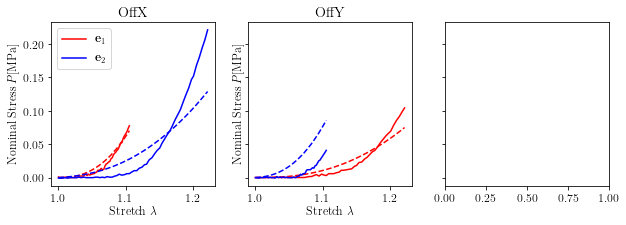

In [57]:
fig,ax = plt.subplots(1,3,figsize=(10,3),sharey=True)

lam1_1 = AX[:,0]
lam1_2 = AX[:,2]
PE1_1 = AX[:,1]
PE1_2 = AX[:,3]
Parr1 = np.zeros([len(lam1_1),2])
for i in range(0,len(lam1_1)):
        P = evalPP(optB.x,lam1_1[i],lam1_2[i])
        Parr1[i,0] = P[0,0]
        Parr1[i,1] = P[1,1]

        
lam2_1 = AY[:,0]
lam2_2 = AY[:,2]
PE2_1 = AY[:,1]
PE2_2 = AY[:,3]
Parr2 = np.zeros([len(lam2_1),2])
for i in range(0,len(lam2_1)):
        P = evalPP(optB.x,lam2_1[i],lam2_2[i])
        Parr2[i,0] = P[0,0]
        Parr2[i,1] = P[1,1]

# lam3_1 = AE[:,0]
# lam3_2 = AE[:,2]
# PE3_1 = AE[:,1]
# PE3_2 = AE[:,3]
# Parr3 = np.zeros([len(lam3_1),2])
# for i in range(0,len(lam3_1)):
#         P = evalP(optA.x,lam3_1[i],lam3_2[i])
#         Parr3[i,0] = P[0,0]
#         Parr3[i,1] = P[1,1]
        
ax[0].plot(lam1_1,PE1_1,color='r',label=r'$\mathbf{e}_1$')       
ax[0].plot(lam1_1,Parr1[:,0],'--',color='r')
ax[0].plot(lam1_2,PE1_2,color='b',label=r'$\mathbf{e}_2$')       
ax[0].plot(lam1_2,Parr1[:,1],'--',color='b') 
ax[0].set_title("OffX")
ax[0].set_xlabel(r'Stretch $\lambda$')
ax[0].set_ylabel(r'Nominal Stress $P$[MPa]')
ax[0].legend()

ax[1].plot(lam2_1,PE2_1,color='r',label=r'$\mathbf{e}_1$')       
ax[1].plot(lam2_1,Parr2[:,0],'--',color='r')
ax[1].plot(lam2_2,PE2_2,color='b',label=r'$\mathbf{e}_2$')       
ax[1].plot(lam2_2,Parr2[:,1],'--',color='b')  
ax[1].set_title("OffY")
ax[1].set_xlabel(r'Stretch $\lambda$')
ax[1].set_ylabel(r'Nominal Stress $P$[MPa]')


ax[2].plot(lam3_1,PE3_1,color='r',label=r'$\mathbf{e}_1$')       
ax[2].plot(lam3_1,Parr3[:,0],'--',color='r')
ax[2].plot(lam3_2,PE3_2,color='b',label=r'$\mathbf{e}_2$')       
ax[2].plot(lam3_2,Parr3[:,1],'--',color='b')  
ax[2].set_title("Equi")
ax[2].set_xlabel(r'Stretch $\lambda$')
ax[2].set_ylabel(r'Nominal Stress $P$[MPa]')

plt.tight_layout()
plt.savefig("Img/"+Exp+".png",dpi=300)
plt.show()


## Additional analysis

More characteristics of the response can be characterized by defining the following quantities

- Toe Stiffness: Find the initial linear region by considering 1:n data points and check where linear correlation coefficient between P and lambda drop below a threshold (eg. 0.99) then find the slope of this region
- Calf Stiffness: Stiffness at a given membrane tension (eg 60N/m). Basically find tangent at point where membrane tension reaches a specified value
- Transition Stretch: Stretch value at which the stress strain response becomes nonlinear. Basically the last value on linear correlation analysis

$\textit{Consider only equibiaxial }$

In [66]:
from scipy.stats.stats import pearsonr, linregress #peasron correlation coeffcient between two vectors 
threshold = 0.99 #Threshold to get linear region

In [69]:
transl1 = 0
toe1 = 0
for i in range(6,len(lam3_1)):
    if pearsonr(lam3_1[:i],PE3_1[:i])[0] > threshold: #Check threshhold
        continue
    else: 
        transl1 = lam3_1[i]  #Assign  transition lambda
        toe1,_,_,_,_= linregress(lam3_1[:i],PE3_1[:i]) # Find slope
        break 
transl2 = 0
toe2 = 0
for i in range(3,len(lam3_2)):
    if pearsonr(lam3_2[:i],PE3_2[:i])[0] > threshold: #Check threshhold
        continue
    else: 
        transl2 = lam3_2[i]  #Assign  transition lambda
        toe2,_,_,_,_= linregress(lam3_2[:i],PE3_2[:i]) # Find slope
        break 

In [70]:
print(transl1,transl2) 
print(toe1,toe2)

1.0166693380349414 1.0079032258064518
0.03695093405742291 -0.13050215871956308


In [73]:
# Find slope at 0.2MPa stress to define calf stiffness
val = 0.2 ; calf1 = 0; calf2 = 0; 
idx1 = (np.abs(PE3_1 - val)).argmin()
idx2 = (np.abs(PE3_2 - val)).argmin()
tt = 3
calf1,_,_,_,_= linregress(lam3_1[idx1-tt:idx1+tt],PE3_1[idx1-tt:idx1+tt]) # Find slope by line fitting to +/-  tt elements
calf2,_,_,_,_= linregress(lam3_2[idx2-tt:idx2+tt],PE3_2[idx2-tt:idx2+tt])

In [74]:
print(calf1,calf2)

3.201844257852147 2.1887428655902568
